In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pprint import pprint

In [3]:
import torch
import math
import transformers
from transformers import (
    RobertaConfig,
    RobertaModel,
    AutoTokenizer,
    pipeline,
    AutoModel,
    RobertaTokenizerFast,
    RobertaForQuestionAnswering
)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
import random

In [7]:
random.seed(42)
np.random.seed(42)

In [81]:
from typing import List, Optional, Dict, Union, Tuple

# Fine-Tuning for QA

## Dataset prep

In [9]:
# !!pip install Dataset

### Load Custom dataset

In [10]:
from datasets import Dataset

In [11]:
import functools

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
import re

In [14]:
def load_askathon_clean(path: str) -> pd.DataFrame:
    data = pd.read_csv(path)
    data = data.drop(columns=["Email Address"]).reset_index(drop=True)
    data.rename(columns={
        data.columns[0] : "context",
        data.columns[1]: "id",
        data.columns[2]: "source",
        data.columns[3]: "topics",
        data.columns[4]: "q1",
        data.columns[5]: "a1",
        data.columns[6]: "q2",
        data.columns[7]: "a2",
        data.columns[8]: "q3",
        data.columns[9]: "a3",
        data.columns[10]: "q4",
        data.columns[11]: "a4",
        data.columns[12]: "q5",
        data.columns[13]: "a5"
    }, inplace=True)
    data.drop(columns=["source", "topics"], inplace=True)
    return data

In [15]:
def create_qa_dataset(data: pd.DataFrame) -> pd.DataFrame:
    res = []
    q_keys = [f"q{i}" for i in range(1, 6)]
    a_keys = [f"a{i}" for i in range(1, 6)]
    
    def _index_fn(context: str, answer: str) -> int:
        try:
            return context.lower().index(answer.rstrip(" ,.!?").lower())
        except ValueError:
            return -1
    
    for _df in data.itertuples():
        tmp = []
        context = _df.context.strip()
        for qk, ak in zip(q_keys, a_keys):
            q, a = getattr(_df, qk), getattr(_df, ak)
            
            if not isinstance(a, str):
                continue
            idx = _index_fn(context, a)
            if idx > -1:
                tmp.append(dict(
                    id="".join(re.split(r"[ :/]", _df.id)),
                    context=context,
                    question=q,
                    answer_text=a,
                    answer_start=idx,
                ))
        res.extend(tmp)
    return pd.DataFrame(res)

In [16]:
data_qa = create_qa_dataset(load_askathon_clean("data/qa/Askathon Cleaned responses - Form Responses 1.csv"))

In [17]:
# (max(data_qa["context"], key=lambda x: len(x.split())))

In [18]:
# will be easier for downstream preprocessing
data_qa["answers"] = data_qa[["answer_text", "answer_start"]]\
.apply(lambda r: dict(text=[r[0]], answer_start=[r[1]]), axis=1)

In [19]:
data_qa.head()

,id,context,question,answer_text,answer_start,answers
0,992022143349,The environmental degradation depletes ecosyst...,What issue causes environmental degradation?,Pollution,51,"{'text': ['Pollution'], 'answer_start': [51]}"
1,992022143349,The environmental degradation depletes ecosyst...,What is Pollution is created from?,"vehicle emissions, agricultural runoff, chemic...",162,"{'text': ['vehicle emissions, agricultural run..."
2,992022143349,The environmental degradation depletes ecosyst...,What depletes ecosystems?,Environmental degradation,4,"{'text': ['Environmental degradation '], 'answ..."
3,992022143349,The environmental degradation depletes ecosyst...,What is a pollution source?,A variety of sources,130,"{'text': ['A variety of sources'], 'answer_sta..."
4,912202292720,"High-shear, low-CAPE (HSLC) severe convection ...",How would you characterize HSLC environments a...,Drier lower troposphere and a surface triple-p...,751,{'text': ['Drier lower troposphere and a surfa...


In [20]:
data_qa_train, data_qa_test = train_test_split(data_qa, test_size=0.2)

In [21]:
data_qa_train.shape, data_qa_test.shape

((102, 6), (26, 6))

### Preprocess for training

- tokenization
- chunking
- etc

References:
- https://huggingface.co/docs/transformers/tasks/question_answering
- https://github.com/AmitNikhade/Kaggle/blob/main/chaii%20-%20Hindi%20and%20Tamil%20Question%20Answering/question-answering-roberta-starter-explained.ipynb

In [22]:
# tokenizer = AutoTokenizer.from_pretrained("data/nasawiki-v6/")
tokenizer = AutoTokenizer.from_pretrained("data/sq2-v6/train-watbertv6-squad-2ep/")
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")

In [23]:
tokenizer.name_or_path

'data/sq2-v6/train-watbertv6-squad-2ep/'

In [24]:
tokenizer.max_len_single_sentence, tokenizer.padding_side

(510, 'right')

In [25]:
# tokenizer.padding_side == "right"

In [28]:
def preprocess_function(examples, tokenizer, max_length=384, stride=128):
#     questions = list(map(lambda x: x["question"], examples))
    inputs = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_mapping = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        
        input_ids = inputs["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        
        sequence_ids = inputs.sequence_ids(i)
        
        sample_index = sample_mapping[i]

        answer = answers[sample_index]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])


        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [29]:
# preprocess_function(data_qa_train.iloc[:2, :])

In [30]:
train_dataset = Dataset.from_pandas(data_qa_train)
test_dataset = Dataset.from_pandas(data_qa_test)

In [31]:
len(train_dataset), len(test_dataset)

(102, 26)

In [50]:
tokenized_trains = train_dataset.map(
    functools.partial(preprocess_function, tokenizer=tokenizer, max_length=384, stride=128),
    batched=True,
    remove_columns=train_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [51]:
tokenized_tests = test_dataset.map(
    functools.partial(preprocess_function, tokenizer=tokenizer, max_length=384, stride=128),
    batched=True,
    remove_columns=test_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [52]:
tokenized_trains, tokenized_tests

(Dataset({
     features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
     num_rows: 104
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
     num_rows: 26
 }))

In [55]:
tokenized_trains[0]["input_ids"]["start_"]

{'input_ids': [0,
  5567,
  375,
  685,
  1594,
  1872,
  285,
  820,
  335,
  20624,
  287,
  1565,
  3964,
  285,
  267,
  2761,
  35,
  2,
  2,
  28082,
  392,
  5112,
  3814,
  287,
  267,
  1131,
  1617,
  16,
  3262,
  820,
  292,
  3433,
  820,
  375,
  591,
  1594,
  1872,
  285,
  820,
  335,
  20624,
  287,
  1565,
  3964,
  285,
  267,
  2761,
  18,
  541,
  465,
  3745,
  16,
  731,
  2438,
  298,
  975,
  438,
  339,
  18,
  2198,
  13,
  2608,
  349,
  31692,
  3433,
  820,
  335,
  20624,
  5392,
  16,
  292,
  2563,
  2438,
  298,
  42736,
  438,
  339,
  18,
  2198,
  13,
  2608,
  349,
  3262,
  820,
  3456,
  18,
  541,
  267,
  1030,
  377,
  2183,
  438,
  339,
  18,
  298,
  5783,
  478,
  267,
  3967,
  3748,
  267,
  624,
  1293,
  285,
  31692,
  3433,
  820,
  3456,
  292,
  8204,
  285,
  685,
  31692,
  21170,
  287,
  2817,
  857,
  267,
  12034,
  433,
  34233,
  1777,
  1684,
  299,
  30969,
  267,
  2034,
  285,
  3433,
  820,
  3456,
  292,
  8204,
  87

In [54]:
tokenizer.decode(tokenized_trains[0]["input_ids"])

'<s>What are two important sources of water for drinking in many parts of the world?</s></s>Apart from groundwater mentioned in the above studies, river water and spring water are also important sources of water for drinking in many parts of the world. In this issue, one paper (He et al. 2019) focus on karst spring water for drinking purpose, and another paper (Ahmed et al. 2019) focus on river water quality. In the study by He et al. (2019), the authors analyzed the time series of karst spring water quality and quantity of two karst springs in China using the Mann–Kendall trend test to delineate the variations of spring water quality and quantity under climate change and human activities. They proved in their study that climate change, particularly the decreasing precipitation was responsible for spring discharge attenuation, while anthropogenic activities such as coal mining and quarrying, agriculture and urbanization were responsible for spring water quality deterioration.</s><pad><

## Train

In [56]:
import pathlib

In [57]:
from transformers import TrainingArguments, Trainer, default_data_collator
from transformers import AutoModelForQuestionAnswering

In [58]:
import wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [59]:
model = AutoModelForQuestionAnswering.from_pretrained("data/sq2-v6/train-watbertv6-squad-2ep/")
# model = AutoModelForQuestionAnswering.from_pretrained("data/nasawiki-v6/")
# model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")

Some weights of the model checkpoint at data/sq2-v6/train-watbertv6-squad-2ep/ were not used when initializing RobertaForQuestionAnswering: ['lm_head.dense.bias', 'task_heads.qa_head.classifier.dense.bias', 'task_heads.qa_head.qa_outputs.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'task_heads.qa_head.classifier.out_proj.bias', 'task_heads.qa_head.classifier.out_proj.weight', 'task_heads.qa_head.classifier.dense.weight', 'lm_head.dense.weight', 'task_heads.qa_head.qa_outputs.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

In [60]:
model

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(65536, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [61]:
pathlib.Path(model.name_or_path).stem

'train-watbertv6-squad-2ep'

In [62]:
wandb.login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: nishuah (nish-test). Use `wandb login --relogin` to force relogin


True

In [63]:
wandb.init(
    project="llm-test",
    entity="nish-test",
    tags=["qa", pathlib.Path(model.name_or_path).stem]
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [65]:
train_args = TrainingArguments(
    f"tmp/finetuned/qa/{pathlib.Path(model.name_or_path).stem}",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    gradient_accumulation_steps=8,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=15,
    weight_decay=0.01,
    report_to="wandb",
    logging_steps=1,
)

In [66]:
train_args.output_dir

'tmp/finetuned/qa/train-watbertv6-squad-2ep'

In [67]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=tokenized_trains,
    eval_dataset=tokenized_tests,
    data_collator=default_data_collator,
    tokenizer=tokenizer,
)

In [68]:
trainer.train()

/Users/nishparadox/dev/uah/nasa-impact/llm-experiments/nasa_wiki_v6/venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 104
  Num Epochs = 15
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 45
  Number of trainable parameters = 135783938
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
0,5.785500,5.599750
1,4.541900,3.937743
2,3.042500,2.802520
3,1.881400,2.412601
4,1.434300,2.389620
5,1.179700,2.551411
6,1.073400,2.713697
7,0.997700,2.769324
8,0.514100,2.771827
9,0.579600,2.788648


***** Running Evaluation *****
  Num examples = 26
  Batch size = 4
Saving model checkpoint to tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-3
Configuration saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-3/config.json
Model weights saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-3/pytorch_model.bin
tokenizer config file saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-3/tokenizer_config.json
Special tokens file saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-3/special_tokens_map.json
Deleting older checkpoint [tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-27] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 26
  Batch size = 4
Saving model checkpoint to tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-6
Configuration saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-6/config.json
Model weights saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-6/pytorch_

Configuration saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-39/config.json
Model weights saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-39/pytorch_model.bin
tokenizer config file saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-39/tokenizer_config.json
Special tokens file saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-39/special_tokens_map.json
Deleting older checkpoint [tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-33] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 26
  Batch size = 4
Saving model checkpoint to tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-42
Configuration saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-42/config.json
Model weights saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-42/pytorch_model.bin
tokenizer config file saved in tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-42/tokenizer_config.json
Special tokens file save

TrainOutput(global_step=45, training_loss=1.8422791805532244, metrics={'train_runtime': 1016.1629, 'train_samples_per_second': 1.535, 'train_steps_per_second': 0.044, 'total_flos': 304149424840704.0, 'train_loss': 1.8422791805532244, 'epoch': 14.92})

## predict/evaluate

In [69]:
import evaluate
from rapidfuzz import fuzz

In [70]:
from jury import Jury

In [ ]:
# vanilla -> distil bert
qa_pipe = pipeline(
    "question-answering",
)

In [73]:
qa_pipe = pipeline(
    "question-answering",
    model="tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-45/",
    tokenizer="tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-45/"
)

loading configuration file tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-45/config.json
Model config RobertaConfig {
  "_name_or_path": "tmp/finetuned/qa/train-watbertv6-squad-2ep/checkpoint-45/",
  "architectures": [
    "RobertaForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "decoding_times_with_dropout": 5,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_dropout_rate": 0.25,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token_id": 2,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 65536
}

loading configuration file tmp/finetuned/qa/train-watbertv6-sq

In [74]:
qa_pipe.model

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(65536, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [110]:
predictions = qa_pipe(
    list(map(lambda x: dict(context=x["context"], question=x["question"]), data_qa_test.to_dict("records")))
)

In [111]:
len(predictions)

26

In [112]:
predictions

[{'score': 0.3066351115703583, 'start': 242, 'end': 246, 'answer': 'Dust'},
 {'score': 0.9677391648292542,
  'start': 101,
  'end': 110,
  'answer': 'resources'},
 {'score': 0.16440102458000183, 'start': 82, 'end': 91, 'answer': 'bands 3–7'},
 {'score': 0.08084839582443237,
  'start': 907,
  'end': 995,
  'answer': 'satellite scatterometers have been providing valuable sea surface wind field information'},
 {'score': 0.00781230628490448, 'start': 800, 'end': 801, 'answer': '.'},
 {'score': 0.04603151977062225,
  'start': 583,
  'end': 652,
  'answer': 'dust in the SAL can be drawn into nearby mesoscale convective systems'},
 {'score': 0.006601804867386818,
  'start': 519,
  'end': 540,
  'answer': 'In all global regions'},
 {'score': 0.7251588106155396,
  'start': 583,
  'end': 608,
  'answer': 'half the radar wavelength'},
 {'score': 0.5100980401039124,
  'start': 200,
  'end': 242,
  'answer': '175 km east of Jackson, Mississippi (JAN).'},
 {'score': 0.44714125990867615,
  'start': 8

In [114]:
list(zip(data_qa_test["context"], data_qa_test["question"], data_qa_test["answer_text"], predictions))[0]

('It is estimated that 240 ± 80 million tons of Saharan dust are transported from Africa to the Atlantic Ocean every year [Kaufman et al., 2005]. Dust can directly impact the radiative balance of the earth by absorbing and scattering sunlight. Dust, especially those coated with sulfur and other soluble materials [Levin et al., 1996], can also affect the cloud development by acting as cloud condensation nuclei (CCN), giant CCN (GCCN) and ice nuclei (IN) [DeMott et al., 2003; van den Heever et al., 2006]. Analysis of visible satellite imagery over the east Atlantic shows that the dust in the SAL can be drawn into nearby mesoscale convective systems, which can later develop into TCs. Hurricane Erin (2001) was one example. Although previous studies have shown that large numbers of dust particles can impact the development of shallow convective clouds, the role of CCN on the development of highly organized, strong convective systems such as TCs has not been thoroughly investigated. This stu

In [115]:
def evaluate_fuzzy(gts: List[str], predictions: List[str]):
    _preprocess = lambda x: x.strip(" .,!?").lower()
    gts = list(map(_preprocess, gts))
    predictions = list(map(_preprocess, predictions))
    res = []
    for gt, pred in zip(gts, predictions):
        res.append(fuzz.token_set_ratio(gt, pred))
    return res

wandb: Network error (ConnectionError), entering retry loop.


In [98]:
def evaluate_exact(gts: List[str], predictions: List[str]):
    _preprocess = lambda x: x.strip(" .,!?").lower()
    gts = list(map(_preprocess, gts))
    predictions = list(map(_preprocess, predictions))
    res = []
    for gt, pred in zip(gts, predictions):
        res.append((gt == pred)*100)
    return res

71.56862745098039


Text(0.5, 1.0, 'Ground truth vs prediction exact match')

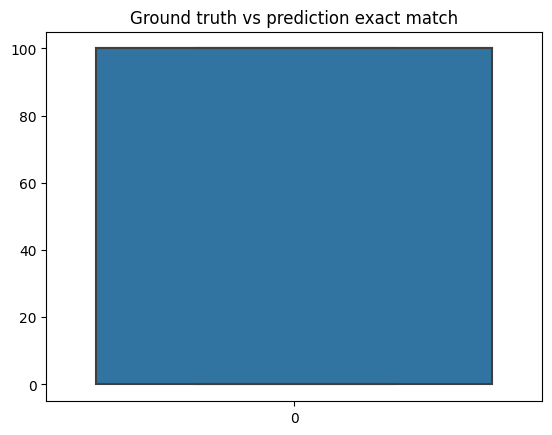

In [101]:
res = evaluate_exact(
    data_qa_train["answer_text"].to_list(),
    list(map(lambda p: p["answer"], predictions)),
)
print(np.mean(res))
sns.boxplot(res)
plt.title("Ground truth vs prediction exact match")

In [106]:
_preprocess_fn = lambda x: x.strip(" .,!?").lower()

In [107]:
def evaluate_jury(predictions: List[str], references: List[str]) -> dict:
    eval_1 = Jury()(predictions=predictions, references=references)
    eval_2 = Jury(metrics=["exact_match", "bleu", "squad"])(predictions=predictions, references=references)
    eval_2.update(eval_1)
    return eval_2

In [108]:
evaluate_jury(
    predictions=list(map(lambda p: p["answer"], predictions)),
    references=data_qa_train["answer_text"].to_list(),
)

{'total_items': 102,
 'empty_items': 0,
 'exact_match': 0.47058823529411764,
 'bleu': {'score': 0.4377416264384578,
  'precisions': [0.9660297239915074,
   0.962059620596206,
   0.9581881533101045,
   0.9547511312217195],
  'brevity_penalty': 0.4558631461080209,
  'length_ratio': 0.5600475624256838,
  'translation_length': 471,
  'reference_length': 841},
 'squad': {'exact_match': 0.7156862745098038, 'f1': 0.8327083419560766},
 'bleu_1': {'score': 0.44037734921263166,
  'precisions': [0.9660297239915074],
  'brevity_penalty': 0.4558631461080209,
  'length_ratio': 0.5600475624256838,
  'translation_length': 471,
  'reference_length': 841},
 'bleu_2': {'score': 0.43947150565346144,
  'precisions': [0.9660297239915074, 0.962059620596206],
  'brevity_penalty': 0.4558631461080209,
  'length_ratio': 0.5600475624256838,
  'translation_length': 471,
  'reference_length': 841},
 'bleu_3': {'score': 0.43858008555336175,
  'precisions': [0.9660297239915074, 0.962059620596206, 0.9581881533101045],

wandb: Network error (ConnectionError), entering retry loop.
